In [2]:
import astropy.units as u
from astropy.constants import c
import astropy.constants as const
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, Angle, ICRS, ITRS, get_icrs_coordinates
from astropy.wcs import WCS
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import matplotlib.patches as patches
import pandas as pd
from astropy.coordinates import get_sun, get_body
import scipy.optimize as op
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
from matplotlib.ticker import StrMethodFormatter
import matplotlib
from astropy.io import fits
from sklearn.decomposition import PCA

mpl.rcParams['xtick.labelsize'] = 14 
mpl.rcParams['ytick.labelsize'] = 14 
mpl.rcParams['pdf.fonttype']=42


%matplotlib notebook

In [4]:
def get_time_delay(origin,site1,site2,alt1,az1,dist1,time):
    src_location = AltAz(az=az1*u.degree,alt=alt1*u.degree,distance=dist1*u.m,location=origin,obstime=time)
    #src_location_icrs = src_location.transform_to(ICRS())
    src_site1 = src_location.transform_to(AltAz(obstime = time,location=site1))
    #src_site1 = AltAz(az=az1*u.degree,alt=alt1*u.degree,distance=dist1*u.m,location=site1,obstime=time)
    #src_site1_icrs = src_site1.transform_to(ICRS())
    src_site2 = src_location.transform_to(AltAz(obstime = time,location=site2))
    time_delay = (src_site1.distance-src_site2.distance)/c
    return time_delay

def get_time_delay_radec(origin,site1,site2,dec,ra,dist1,time):
    #src_location = AltAz(az=az1*u.degree,alt=alt1*u.degree,distance=dist1*u.m,location=origin,obstime=time)
    #src_location_icrs = src_location.transform_to(ICRS())
    src = ICRS(ra*u.deg,dec*u.deg,distance=dist1*u.m)
    #src_origin = src.transform_to(AltAz(obstime = time,location=origin,distance=dist1*u.m))
    #src_origin_icrs = src_origin.transform_to(ICRS())
    loc1 = AltAz(obstime = time,location=site1)
    loc2 = AltAz(obstime = time,location=site2)
    src_site1 = src.transform_to(loc1)
    #src_site1 = AltAz(az=az1*u.degree,alt=alt1*u.degree,distance=dist1*u.m,location=site1,obstime=time)
    src_site2 = src.transform_to(loc2)
    time_delay = (src_site1.distance-src_site2.distance)/c
    return time_delay

def calculate_delay(origin,site1,site2,alt1,az1,dist1,time):
    src_location = AltAz(az=az1*u.degree,alt=alt1*u.degree,distance=dist1*u.m,location=origin,obstime=time)
    src_location_icrs = src_location.transform_to(ICRS())
    src_site1 = src_location_icrs.transform_to(AltAz(obstime = time,location=site1))
    #src_site1 = AltAz(az=az1*u.degree,alt=alt1*u.degree,distance=dist1*u.m,location=site1,obstime=time)
    #src_site1_icrs = src_site1.transform_to(ICRS())
    src_site2 = src_location_icrs.transform_to(AltAz(obstime = time,location=site2))
    time_delay = (src_site1.distance-src_site2.distance)/c
    return time_delay

def get_possible_inds(time_delays,delay, uncertainty):
    possible_inds = np.where(np.logical_and(time_delays < (delay+uncertainty)*1e-6, time_delays > (delay-uncertainty)*1e-6))
    return np.array([possible_inds[0],possible_inds[1]])

def distances(raarr,decarr,rafunc,decfunc):
    dists = np.zeros(len(raarr))
    for i in range(len(raarr)):
        #dists[i] = np.min(np.arccos(np.cos(np.pi/4-decarr[i]*np.pi/180.)*np.cos(np.pi/4-decfunc*np.pi/180.) \
        #    + np.sin(np.pi/4-decarr[i]*np.pi/180.)*np.sin(np.pi/4-decfunc*np.pi/180.) \
        #    * np.cos(raarr[i]*np.pi/180.-rafunc*np.pi/180.)))
        dists[i] = np.min(np.sqrt((raarr[i]-rafunc)**2+(decarr[i]-decfunc)**2))
    return dists

def get_prob(dists,width):
    return 1./(np.sqrt(width**2*2*np.pi))*np.exp(-0.5*(dists)**2/(width)**2)

def ellipse_eq(ras,decs,x0,y0,alpha,a,b):
    ellipse_inds = (((ras[:-1]-x0)*np.cos(-alpha*np.pi/180.) + (decs[:-1,None]-y0)*np.sin(-alpha*np.pi/180.))/(a))**2 \
     +(((ras[:-1]-x0)*np.sin(-alpha*np.pi/180.)-(decs[:-1,None]-y0)*np.cos(-alpha*np.pi/180.))/(b))**2 <=1
    return ellipse_inds

def loss_func(probabilities, ras,decs,p,conf_interval,lamb):
    e_ps = np.sum(probabilities[ellipse_eq(ras,decs,p[0],p[1],p[2],p[3],p[4])])
    loss = np.abs(e_ps-conf_interval)**2+lamb**2*p[4]/(92.)
    return loss

def loss_func_noreg(probabilities, ras,decs,p,conf_interval):
    e_ps = np.sum(probabilities[ellipse_eq(ras,decs,p[0],p[1],p[2],p[3],p[4])])
    loss = np.abs(e_ps-conf_interval)
    return loss

def pdlossfunc(epsilon,probabilities,ras,decs,p,conf_interval,lamb):
    stepsizes = p*epsilon
    low_ps = np.ones(5)
    high_ps = np.ones(5)
    lows = np.ones(5)
    highs = np.ones(5)
    for i in range(len(p)):
        p[i] -=stepsizes[i]
        low_ps[i] = p[i]
        lows[i] = loss_func(probabilities,ras,decs,p,conf_interval,lamb)
        p[i] +=2*stepsizes[i]
        high_ps[i] = p[i]
        highs = loss_func(probabilities,ras,decs,p,conf_interval,lamb)
        p[i] -= stepsizes[i]
    gradients = (highs-lows)/(2*stepsizes)
    gradients[:3] = 0
    return gradients

def fit(epsilon,probabilities,ras,decs,p0,conf_interval,lamb,max_iter,converge,learn_rate):
    losses = np.array([1000])
    losses = np.append(losses,loss_func(probabilities,ras,decs,p0,conf_interval,lamb))
    losses_noreg = np.array([])
    losses_noreg = np.append(losses_noreg,loss_func_noreg(probabilities,ras,decs,p0,conf_interval))
    iteration = 0
    print(losses[0],losses_noreg[0],p0)
    while iteration < max_iter and np.abs(losses[-2] - losses[-1]) > converge:
        grad = pdlossfunc(epsilon,probabilities,ras,decs,p0,conf_interval,lamb)
        p0 = p0 - learn_rate*grad
        losses = np.append(losses,loss_func(probabilities,ras,decs,p0,conf_interval,lamb))
        losses_noreg = np.append(losses_noreg,loss_func_noreg(probabilities,ras,decs,p0,conf_interval))
        print(losses[iteration+1],losses_noreg[iteration+1],p0)
        iteration+=1
    return p0,losses,losses_noreg

In [4]:
ovro = EarthLocation(lat = 37.233248 * u.deg, lon = -118.283393 * u.deg, height = 1207*u.m)
gdscc = EarthLocation(lat = 35.247531 * u.deg, lon = -116.791717 * u.deg, height = 1073*u.m)
delta = EarthLocation(lat = 39.338363 * u.deg, lon = -112.700681 * u.deg, height = 1398*u.m)

In [12]:
time = Time(dt.datetime(2020,4,28,14,34,25,26100))

ovro_azs = np.linspace(0,360,5760)
ovro_els = np.linspace(0,90.,1440)

farfield = 332689574226.93726
og_time_delays = np.zeros(len(ovro_azs)*len(ovro_els)).reshape(len(ovro_azs),len(ovro_els))
od_time_delays = np.zeros(len(ovro_azs)*len(ovro_els)).reshape(len(ovro_azs),len(ovro_els))
gd_time_delays = np.zeros(len(ovro_azs)*len(ovro_els)).reshape(len(ovro_azs),len(ovro_els))
for i in range(len(ovro_azs)):
        if i%100 == 0:
            print(i)
        og_delay = get_time_delay(ovro,ovro,gdscc,ovro_els,ovro_azs[i],farfield,time)
        od_delay = get_time_delay(ovro,ovro,delta,ovro_els,ovro_azs[i],farfield,time)
        gd_delay = get_time_delay(ovro,gdscc,delta,ovro_els,ovro_azs[i],farfield,time)
        og_time_delays[i] = og_delay.value
        od_time_delays[i] = od_delay.value
        gd_time_delays[i] = gd_delay.value

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700


In [13]:
np.save("ovro_gdscc_time_delays_lookup2",og_time_delays)
np.save("ovro_delta_time_delays_lookup2",od_time_delays)
np.save("gdscc_delta_time_delays_lookup2",gd_time_delays)

In [5]:
og_time_delays = np.load("ovro_gdscc_time_delays_lookup2.npy")
od_time_delays = np.load("ovro_delta_time_delays_lookup2.npy")
gd_time_delays = np.load("gdscc_delta_time_delays_lookup2.npy")

In [6]:
measured_og_delay = -7.
measured_od_delay = -884.
measured_gd_delay = -888.

uncertainty = np.array([36,23,36])
uncertainty_sys = np.sqrt(uncertainty**2+88**2)*2

In [7]:

og_possible_inds = get_possible_inds(og_time_delays,measured_og_delay, uncertainty[0])
od_possible_inds = get_possible_inds(od_time_delays,measured_od_delay, uncertainty[1])
gd_possible_inds = get_possible_inds(gd_time_delays,measured_gd_delay, uncertainty[2])
og_possible_inds_sys = get_possible_inds(og_time_delays,measured_og_delay, uncertainty_sys[0])
od_possible_inds_sys = get_possible_inds(od_time_delays,measured_od_delay, uncertainty_sys[1])
gd_possible_inds_sys = get_possible_inds(gd_time_delays,measured_gd_delay, uncertainty_sys[2])
og_possible_inds_small = get_possible_inds(og_time_delays,measured_og_delay, 5)
od_possible_inds_small = get_possible_inds(od_time_delays,measured_od_delay, 5)
gd_possible_inds_small = get_possible_inds(gd_time_delays,measured_gd_delay, 5)

possible_inds_arr = [og_possible_inds,od_possible_inds,gd_possible_inds,og_possible_inds_sys,od_possible_inds_sys,gd_possible_inds_sys,og_possible_inds_small,od_possible_inds_small,gd_possible_inds_small]
radecs = []
sites = [ovro,ovro,gdscc,ovro,ovro,gdscc,ovro,ovro,gdscc]
print(time)
for i in range(len(possible_inds_arr)):
    srces = AltAz(obstime=time,location=sites[i],az = ovro_azs[possible_inds_arr[i][0]]*u.degree,alt = ovro_els[possible_inds_arr[i][1]]*u.degree)
    srces_radec = srces.transform_to(ICRS())
    radecs.append(np.array([srces_radec.ra.degree,srces_radec.dec.degree]))


NameError: name 'ovro' is not defined

In [ ]:
binsize=0.01
rarange = np.array([220,340])
decrange = np.array([-60,60])
binrange = np.array([int((rarange[1]-rarange[0])/binsize),int((decrange[1]-decrange[0])/binsize)])

oghist = np.histogram2d(radecs[3][0],radecs[3][1],bins=binrange,range=[rarange,decrange])
odhist = np.histogram2d(radecs[4][0],radecs[4][1],bins=binrange,range=[rarange,decrange])
gdhist = np.histogram2d(radecs[5][0],radecs[5][1],bins=binrange,range=[rarange,decrange])
oghists = np.histogram2d(radecs[6][0],radecs[6][1],bins=binrange,range=[rarange,decrange])
odhists = np.histogram2d(radecs[7][0],radecs[7][1],bins=binrange,range=[rarange,decrange])
gdhists = np.histogram2d(radecs[8][0],radecs[8][1],bins=binrange,range=[rarange,decrange])

In [8]:
raindog = np.where(oghist[0] !=0)[0]
raindod = np.where(odhist[0] !=0)[0]
raindgd = np.where(gdhist[0] !=0)[0]
raindogm = np.where(oghists[0] !=0)[0]
raindodm = np.where(odhists[0] !=0)[0]
raindgdm = np.where(gdhists[0] !=0)[0]
decindog = np.where(oghist[0] !=0)[1]
decindod = np.where(odhist[0] !=0)[1]
decindgd = np.where(gdhist[0] !=0)[1]
decindogm = np.where(oghists[0] !=0)[1]
decindodm = np.where(odhists[0] !=0)[1]
decindgdm = np.where(gdhists[0] !=0)[1]
rasog = oghist[1][np.where(oghist[0] !=0)[0]]
decsog = oghist[2][np.where(oghist[0] !=0)[1]]
rasod = odhist[1][np.where(odhist[0] !=0)[0]]
decsod = odhist[2][np.where(odhist[0] !=0)[1]]
rasgd = gdhist[1][np.where(gdhist[0] !=0)[0]]
decsgd = gdhist[2][np.where(gdhist[0] !=0)[1]]
rasogm = gdhists[1][np.where(oghists[0] !=0)[0]]
decsogm = oghists[2][np.where(oghists[0] !=0)[1]]
rasodm = oghists[1][np.where(odhists[0] !=0)[0]]
decsodm = odhists[2][np.where(odhists[0] !=0)[1]]
rasgdm = gdhists[1][np.where(gdhists[0] !=0)[0]]
decsgdm = gdhists[2][np.where(gdhists[0] !=0)[1]]

NameError: name 'oghist' is not defined

In [9]:
mbases = [[rasogm,decsogm],[rasodm,decsodm],[rasgdm,decsgdm]]
decs = np.zeros((3,binrange[0]))
decfunc = []
binsize2 = mbases[0][0][1]-mbases[0][0][0]
for k in range(0,3):
    count=0
    for i in range(binrange[0]):
        bininds = np.where(np.logical_and(mbases[k][0]>oghist[1][i]-10*binsize/2,mbases[k][0]<oghist[1][i]+10*binsize2/2))
        #print(bininds,oghist[1][i]-binsize*10/2,oghist[1][i] \
        #      +binsize*10/2,len(np.where(mbases[k][0]>oghist[1][i]-binsize/2)[0]),\
        #      len(np.where(mbases[k][0]<oghist[1][i]+binsize/2)[0]),\
        #      len(np.where(np.where(mbases[k][0]>oghist[1][i]-binsize/2)[0] \
        #        ==np.sum(mbases[k][0]<oghist[1][i]+binsize/2))[0]),mbases[k][1][bininds])
        decs[k][count] = np.mean(mbases[k][1][bininds])
        count+=1
    decs[k][np.where(np.isnan(decs[k]))] = 0.
    decfunc.append(decs[k])
print(mbases[k][0])
print(len(decfunc[0]),len(mbases[0][0]))
decfunc = np.array(decfunc)
print(raindog.max(),binrange)
#pd.Series(y_pred).plot(ax=axarr[0], color='steelblue')
#pd.Series(y).plot(ax=axarr[0], marker="o", linewidth=0, color='black')
print(decsog.shape,len(decfunc[0][raindog]))
print(decfunc)

NameError: name 'rasogm' is not defined

In [10]:
distsog = distances(rasog,decsog,oghist[1][:-1],decfunc[0])
distsod = distances(rasod,decsod,oghist[1][:-1],decfunc[1])
distsgd = distances(rasgd,decsgd,oghist[1][:-1],decfunc[2])

NameError: name 'rasog' is not defined

In [29]:
og_3sdist = 20. #radius
od_3sdist = 10.7 #radius
#od_1sdist = 3.3
gd_3sdist = 10.

probsog = get_prob(distsog,og_3sdist/3.)
probsod = get_prob(distsod,od_3sdist/3.)
probsgd = get_prob(distsgd,gd_3sdist/3.)

In [30]:
probsimog = np.zeros(oghist[0].shape)
probsimog[raindog,decindog] = probsog
probsimod = np.zeros(oghist[0].shape)
probsimod[raindod,decindod] = probsod
probsimgd = np.zeros(oghist[0].shape)
probsimgd[raindgd,decindgd] = probsgd
probs_final = probsimog*probsimod*probsimgd
probs_final = probs_final/probs_final.sum()

In [31]:
np.save("final_localization2.npy",probs_final)
np.save("ra_bins2.npy",oghist[1])
np.save("dec_bins2.npy",oghist[2])

In [36]:
probs = np.load("final_localization2.npy")
ras = np.load("ra_bins2.npy")
decs = np.load("dec_bins2.npy")


result = gaussian_filter(probs,100)
probs_final = result/np.sum(result)
probs_final[np.where(result<1e-10)] = 0.

In [37]:
prob_inds = np.where(result/np.sum(result) > 8e-8)
pcainds = np.array(prob_inds).T
pca = PCA(n_components=2)
pca.fit(pcainds)
angle = np.arctan(pca.components_[0,0]/pca.components_[0,1])

In [5]:
raprob = (result/np.sum(result)).mean(axis=0)
raprob = raprob/np.sum(raprob)
decprob = (result/np.sum(result)).mean(axis=1)
decprob = decprob/np.sum(decprob)
ra_value = np.sum(ras[:-1]*raprob)
dec_value = np.sum(decs[:-1]*decprob)
print(ra_value)
print(dec_value)

298.63477796355147
13.787739597832358


In [6]:
raind = np.where(np.abs(ra_value-ras[:-1]) == np.min(np.abs(ra_value-ras[:-1])))[0][0]
decind = np.where(np.abs(dec_value-decs[:-1]) == np.min(np.abs(dec_value-decs[:-1])))[0][0]

ra_lower = np.array([])
ra_upper = np.array([])
dec_lower = np.array([])
dec_upper = np.array([])
for i in range(len(raprob)):
    if i< raind:
        ra_lower = np.append(ra_lower,raprob[i:raind].sum())
    elif i>=raind:
        ra_upper = np.append(ra_upper,raprob[raind:i].sum())
    if i< decind:
        dec_lower = np.append(dec_lower,decprob[i:decind].sum())
    elif i>= decind:
        dec_upper = np.append(dec_upper,decprob[decind:i].sum())
ra_1sigmal = ras[np.where(np.abs(ra_lower-.341) == np.min(np.abs(ra_lower-.341)))[0][0]]
ra_1sigmau = ras[np.where(np.abs(ra_upper-.341) == np.min(np.abs(ra_upper-.341)))[0][0]+raind]
dec_1sigmal = decs[np.where(np.abs(dec_lower-.341) == np.min(np.abs(dec_lower-.341)))[0][0]]
dec_1sigmau = decs[np.where(np.abs(dec_upper-.341) == np.min(np.abs(dec_upper-.341)))[0][0]+decind]
print(ra_1sigmal,ra_1sigmau,dec_1sigmal,dec_1sigmau)
    

294.96000000000004 302.12 8.930000000000007 18.17


In [85]:
#p,losses,losses_noreg = fit(0.1,result/np.sum(result),ras,decs,np.array([ra_value,  dec_value,   np.degrees(np.abs(angle)),\
#                                                                         12.3,5.85]), 0.95,0.05,100,0.000000001,1.)
p,losses,losses_noreg = fit(0.1,result/np.sum(result),ras,decs,np.array([ra_value,  dec_value,   np.degrees(np.abs(angle)),\
                                                                         12.3,5.85]), 0.682,0.05,100,0.000000001,1.)

1000.0 0.0005740572926432597 [298.63477796  13.7877396   58.12821307  12.3          5.85      ]
0.00015929693307958475 0.0005597950203595214 [298.63477796  13.7877396   58.12821307  12.30012082   5.85034629]
0.00015929017174785213 0.0005452770664090556 [298.63477796  13.7877396   58.12821307  12.30024129   5.85069154]
0.00015928351027471075 0.0005333067336145136 [298.63477796  13.7877396   58.12821307  12.30036133   5.85103572]
0.00015927995190725554 0.0005197066422967245 [298.63477796  13.7877396   58.12821307  12.30048099   5.85137886]
0.00015927495528008048 0.00050720357708256 [298.63477796  13.7877396   58.12821307  12.30060026   5.85172086]
0.00015927140931932987 0.0004937485441940392 [298.63477796  13.7877396   58.12821307  12.30071912   5.85206159]
0.00015926720038531868 0.00048085767433092563 [298.63477796  13.7877396   58.12821307  12.30083761   5.85240142]
0.00015926387128897143 0.00046849516471414443 [298.63477796  13.7877396   58.12821307  12.30095573   5.85274016]
0.000159

In [7]:
p=[298.63477796,  13.7877396,   58.12821307,  12.30154055,   5.85441856]
ellipse = (((ras[:-1]-ra_value)*np.cos(angle) + (decs[:-1,None]-dec_value)*np.sin(angle))/(p[3]))**2 \
     +(((ras[:-1]-ra_value)*np.sin(angle)-(decs[:-1,None]-dec_value)*np.cos(angle))/(p[4]))**2 <=1
ellipse2 = (((ras[:-1]-ra_value)*np.cos(angle) + (decs[:-1,None]-dec_value)*np.sin(angle))/(8.1))**2 \
     +(((ras[:-1]-ra_value)*np.sin(angle)-(decs[:-1,None]-dec_value)*np.cos(angle))/(3.85))**2 <=1
ellipse3 = (((ras[:-1]-ra_value)*np.cos(angle) + (decs[:-1,None]-dec_value)*np.sin(angle))/(11.1))**2 \
     +(((ras[:-1]-ra_value)*np.sin(angle)-(decs[:-1,None]-dec_value)*np.cos(angle))/(5.25))**2 <=1

In [8]:
print(np.sum(result[ellipse])/np.sum(result))
print(np.sum(result[ellipse2])/np.sum(result))
print(np.sum(result[ellipse3])/np.sum(result))

0.949599616874402
0.683289097880905
0.9003500608211076


<IPython.core.display.Javascript object>


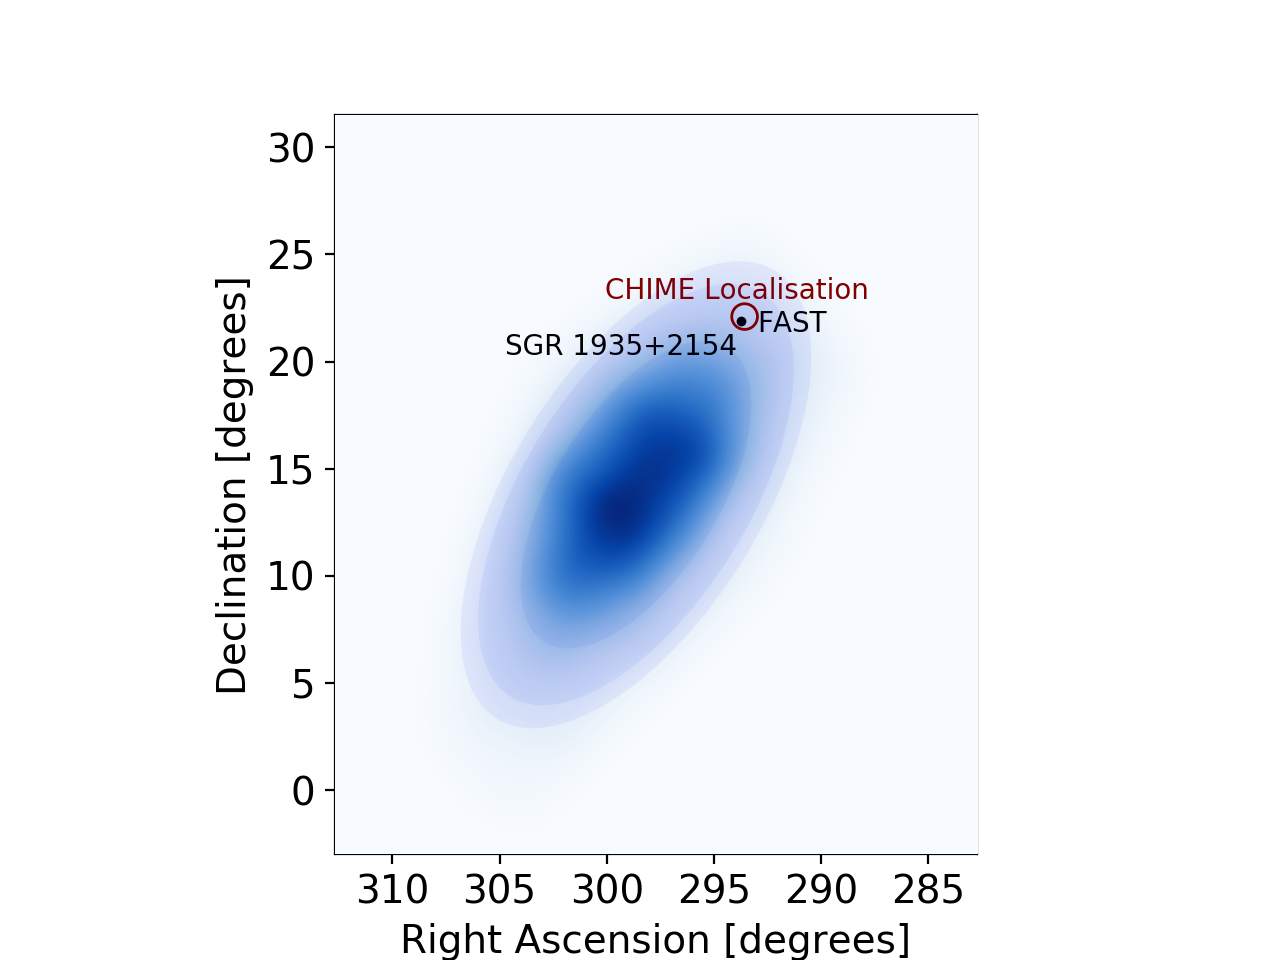

Text(0.5, 0, 'Right Ascension [degrees]')

In [48]:
magnetar = SkyCoord(ra='19h34m55.68s',dec='21d53m58.2s')
raoffset = 2*(magnetar.ra.degree - np.median(ras))
chimeloc = SkyCoord(ra=293.9*u.degree,dec=22.1*u.degree)


f,ax= plt.subplots()
ax.set_ylim(-3,31.5)
ax.set_xlim(312.7-2*(312.7 - np.median(ras)),282.7-2*(282.7 - np.median(ras)))
im1=ax.imshow(np.flip(np.flip(probs_final,axis=0),axis=1),cmap='Blues',extent = [ras.min(),ras.max(),decs.min(),decs.max()],zorder=3)
#im2=ax.imshow(np.flip(np.flip(ellipse*np.max(result/np.sum(result))/20.,axis=0),axis=1),cmap='Blues',extent = [ras.min(),ras.max(),decs.min(),decs.max()],alpha=0.1,zorder=6)
#im3=ax.imshow(np.flip(np.flip(ellipse2*np.max(result/np.sum(result))/20.,axis=0),axis=1),cmap='Blues',extent = [ras.min(),ras.max(),decs.min(),decs.max()],alpha=0.1,zorder=4)
#im4=ax.imshow(np.flip(np.flip(ellipse3*np.max(result/np.sum(result))/20.,axis=0),axis=1),cmap='Blues',extent = [ras.min(),ras.max(),decs.min(),decs.max()],alpha=0.1,zorder=5)
ell1 = matplotlib.patches.Ellipse((ra_value-2*(ra_value-np.median(ras)),dec_value),width=p[3]*2,height=p[4]*2,angle=58.12821307,alpha=0.05,zorder=8,fill=True,facecolor='Blue',edgecolor='None')
ell2 = matplotlib.patches.Ellipse((ra_value-2*(ra_value-np.median(ras)),dec_value),width=8.1*2,height=3.85*2,angle=58.12821307,alpha=0.05,zorder=7,fill=True,facecolor='Blue',edgecolor='None')
ell3 = matplotlib.patches.Ellipse((ra_value-2*(ra_value-np.median(ras)),dec_value),width=11.1*2,height=5.25*2,angle=58.12821307,alpha=0.05,zorder=6,fill=True,facecolor='Blue',edgecolor='None')
ax.add_artist(ell1)
ax.add_artist(ell2)
ax.add_artist(ell3)
#ell = mpl.patches.Ellipse((298.654 - 2*(298.654- np.median(ras)),13.841),6.53,13.6,angle*180./np.pi,color='blue',alpha=0.5,zorder=4)
#ax.add_patch(ell)
ax.scatter(magnetar.ra.degree-raoffset, magnetar.dec.degree,marker = '.', s = 25,color='k',zorder=6+1)
ax.text(magnetar.ra.degree-raoffset+1-12., magnetar.dec.degree-1.6,'SGR 1935+2154',color='k',zorder=6+2)
ax.text(magnetar.ra.degree-raoffset+.75, magnetar.dec.degree-0.5,'FAST',color='k',zorder=6+2)
circle1 = plt.Circle((chimeloc.ra.degree-raoffset, chimeloc.dec.degree), 0.6, color='#800000',fill=False,zorder=6+3)
ax.add_artist(circle1)
#ax.scatter(chimeloc.ra.degree-raoffset, chimeloc.dec.degree,marker = 'o', s = 100,color='k',zorder=4+1,fil='none')
#ax.scatter(chimeloc.ra.degree-raoffset, chimeloc.dec.degree,marker = 0, s = 400,color='k',zorder=4+1)
ax.text(chimeloc.ra.degree-raoffset+1.-7.5, chimeloc.dec.degree+0.8,'CHIME Localisation',color='#800000',zorder=4+3)
#locs = ax.get_xticks()
#print(locs)
#newticks = locs-2*(locs-np.median(ras))
#print(newticks)       
#ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
#ax.set_xticklabels(newticks.astype('|S3'))
ax.set_xticks([250,255,260,265,270,275])
ax.set_xticklabels(['310','305','300','295','290','285'])
ax.set_ylabel("Declination [degrees]",fontsize=14)
ax.set_xlabel("Right Ascension [degrees]",fontsize=14)

In [49]:
f.savefig("localization_region_rev_left.pdf")